In [8]:
import scanpy as sc
import anndata as ad
import scanpy.external as sce
from anndata import AnnData

In [15]:
# paths
nsg_bus_1 = "/mnt/shared/nationwide/Counts/NSG_BUS_1/outs/filtered_feature_bc_matrix.h5"
nsg_bus_2 = "/mnt/shared/nationwide/Counts/NSG_BUS_2/outs/filtered_feature_bc_matrix.h5"
nsg_bus_3 = "/mnt/shared/nationwide/Counts/NSG_BUS_3/outs/filtered_feature_bc_matrix.h5"

nsg_ctl_1 = "/mnt/shared/nationwide/Counts/NSG_CNTL_1/outs/filtered_feature_bc_matrix.h5"
nsg_ctl_2 = "/mnt/shared/nationwide/Counts/NSG_CNTL_2/outs/filtered_feature_bc_matrix.h5"
nsg_ctl_3 = "/mnt/shared/nationwide/Counts/NSG_CNTL_3/outs/filtered_feature_bc_matrix.h5"

nsg_s_bus_1 = "/mnt/shared/nationwide/Counts/NSG_S_BUS_1/outs/filtered_feature_bc_matrix.h5"
nsg_s_bus_2 = "/mnt/shared/nationwide/Counts/NSG_S_BUS_2/outs/filtered_feature_bc_matrix.h5"
nsg_s_bus_3 = "/mnt/shared/nationwide/Counts/NSG_S_BUS_3/outs/filtered_feature_bc_matrix.h5"

nsg_s_ctl_1 = "/mnt/shared/nationwide/Counts/NSG_S_CNTL_1/outs/filtered_feature_bc_matrix.h5"
nsg_s_ctl_2 = "/mnt/shared/nationwide/Counts/NSG_S_CNTL_2/outs/filtered_feature_bc_matrix.h5"
nsg_s_ctl_3 = "/mnt/shared/nationwide/Counts/NSG_S_CNTL_3/outs/filtered_feature_bc_matrix.h5"

In [22]:
class Integration:
    def apply(datasets: list, method: str = "scanorama", key: str = "Trial", resolution: int = 0.3) -> AnnData:
        """
        Parameters:
            Datasets: list of datasets to concatenate
            Method: Integration Method
            Key: Key differentiating different datasets 
            Resolution: Clustering resolution
            will add additional parameters for normalization
            
        Return Value: AnnData object containing PCA, Integration, Nearest Neighbor, UMAP, and Clustering results
        """
        for i in range(len(datasets)):
            sc.pp.recipe_zheng17(datasets[i]) # runs a predefined normalization process.
    
        dataset = ad.concat(datasets)
        sc.pp.pca(dataset)
        if method == "scanorama":
            sce.pp.scanorama_integrate(dataset, key, verbose=1)
            sc.pp.neighbors(dataset, use_rep="X_scanorama")
        elif method == "harmony":
            sce.pp.harmony_integrate(dataset, key, verbose=1)
            sc.pp.neighbors(dataset, use_rep="X_pca_harmony")
        elif method == "merge":
            sc.pp.neighbors(dataset, use_rep="X_pca")
        else:
            raise ValueError("Invalid Integration Method")
        sc.tl.umap(dataset)
        sc.tl.leiden(
            dataset, key_added="clusters", n_iterations=2, directed=False, resolution=resolution
        )
        sc.pl.umap(
            dataset, color=["clusters"], palette=sc.pl.palettes.default_20
        )
        return dataset

In [23]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def score_clusters(dataset: AnnData, key: str = "clusters", random_state: int = 42) -> tuple:
    """
    Parameters
        dataset: AnnData object with clusters precalculated
        key: where the clusters are located within ann data object
        random_state: for reproducibility 
    Return Value: silhouette, davies, calinksi clustering scores
    """
    sil = silhouette_score(dataset.X, dataset.obs[key], random_state=random_state)
    davies = davies_bouldin_score(dataset.X, dataset.obs[key])
    calinski = calinski_harabasz_score(dataset.X, dataset.obs[key])
    return sil, davies, calinski

In [24]:
class QC():
    def apply(dataset: AnnData) -> AnnData:
        """
        Parameters:
            dataset: AnnData object
            
        Return Value: A QC'd AnnData object 
        """
        sc.pp.calculate_qc_metrics(dataset, inplace=True)
        sc.pp.filter_cells(dataset, min_genes=100)
        sc.pp.filter_genes(dataset, min_cells=3)
        sc.pp.scrublet(dataset, batch_key="Trial")
        return dataset[dataset.obs["predicted_doublet"] == False]

In [25]:
class Normalization():
    def apply(dataset: AnnData, method: str = "recipe_zheng17") -> AnnData:
        """
        Parameters: 
            dataset: AnnData object
            method: A string indicating how the data should be normalized
        Return Value: A normalized AnnData object
        """

In [26]:
class Pipeline():
    def __init__(self):
        self.steps = []
    def add_step(self, step):
        self.steps.append(step)
    def execute(self, data):
        processed_data = data
        for step in self.steps:
            processed_data = step.process(processed_data)
        return processed_data

# Python R Wrapper

In [82]:
# sc.pp.recipe_zheng17(nsg_bus_1_data)
# sc.pp.recipe_zheng17(nsg_bus_2_data)
# sc.pp.recipe_zheng17(nsg_bus_3_data)
dataset = ad.concat([nsg_bus_1_data, nsg_bus_2_data, nsg_bus_3_data])

/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [75]:
import rpy2.robjects as ro
import anndata2ri

def seurat_cca_wrapper(dataset: AnnData) -> AnnData:
    """
    dataset: Anndata dataset preprocessed through scanpy
    Returns: Anndata dataset with cca applied
    """
    # pass in a list of objects vs one big anndata object?
    anndata2ri.activate()
    ro.globalenv["adata"] = dataset
    ro.r('library(Seurat)')
    ro.r('seurat_obj <- as.Seurat(adata, data = NULL, assay = NULL, counts = "X")')
    ro.r('int_feats <- SelectIntegrationFeatures(list(seurat_obj))')
    ro.r('int_list <- PrepSCTIntegration(object.list = list(seurat_obj),\
                                   anchor.features = int_feats)')
    ro.r('int_anchors <- FindIntegrationAnchors(object.list = int_list,\
                                          normalization.method = "SCT",\
                                          anchor.features = int_feats)')
    ro.r('cca <- IntegrateData(anchorset = int_anchors,\
                     normalization.method = "SCT")')
    ro.r('remove(int_anchors, int_list, int_feats)')
    ro.r('    cca <- cca %>%\
              RunPCA(verbose = FALSE) %>%\
              FindNeighbors(dims = 1:30) %>%\
              RunUMAP(dims = 1:30) %>%\
              FindClusters()')
    ro.r('resolution.range <- seq(from = 0, to = 1, by = 0.1)')
    ro.r('cca <- FindClusters(cca, resolution = resolution.range)')
    ro.r('tree <- clustree(cca)')
    ro.r('cca <- FindClusters(cca, resolution = 0.3)')
    ro.r('cca <- as.SingleCellExperiment(cca)')

    return ro.globalenv["cca"]

In [77]:
seurat_cca_wrapper([nsg_bus_1_data, nsg_bus_2_data, nsg_bus_3_data])

/tmp/ipykernel_53006/1300627276.py:9: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
R[write to console]: Error in UseMethod(generic = "as.Seurat", object = x) : 
  no applicable method for 'as.Seurat' applied to an object of class "list"



RRuntimeError: Error in UseMethod(generic = "as.Seurat", object = x) : 
  no applicable method for 'as.Seurat' applied to an object of class "list"


# NSG Bulsulfan

In [6]:
# read data
nsg_bus_1_data = sc.read_10x_h5(nsg_bus_1)
nsg_bus_2_data = sc.read_10x_h5(nsg_bus_2)
nsg_bus_3_data = sc.read_10x_h5(nsg_bus_3)

# creating metadata
nsg_bus_1_data.obs["Trial"] = "1"
nsg_bus_2_data.obs["Trial"] = "2"
nsg_bus_3_data.obs["Trial"] = "3"

nsg_bus_1_data.var_names_make_unique()
nsg_bus_2_data.var_names_make_unique()
nsg_bus_3_data.var_names_make_unique()

nsg_bus_1_data.obs_names_make_unique()
nsg_bus_2_data.obs_names_make_unique()
nsg_bus_3_data.obs_names_make_unique()

nsg_bus_1_data = qc(nsg_bus_1_data)
nsg_bus_2_data = qc(nsg_bus_2_data)
nsg_bus_3_data = qc(nsg_bus_3_data)

/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: Use

/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:273: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_counts"] = number
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:273: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_counts"] = number
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:273: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_counts"] = number
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Processing datasets 1 <=> 2
Processing datasets 2 <=> 3
Processing datasets 1 <=> 3


/home/user/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/tmp/ipykernel_61468/4177935437.py:27: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


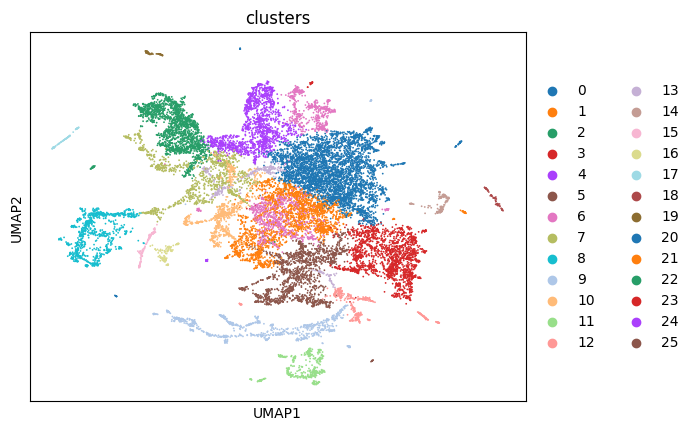

In [13]:
nsg_bus_scan = integrate([nsg_bus_1_data, nsg_bus_2_data, nsg_bus_3_data])

In [14]:
nsg_bus_harm = integrate([nsg_bus_1_data, nsg_bus_2_data, nsg_bus_3_data], method="harmony")

/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:233: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/home/user/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/user/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
nsg_bus_merge = integrate([nsg_bus_1_data, nsg_bus_2_data, nsg_bus_3_data], method="merge")

# NSG CONTROL

In [ ]:
nsg_ctl_1_data = sc.read_10x_h5(nsg_ctl_1)
nsg_ctl_2_data = sc.read_10x_h5(nsg_ctl_2)
nsg_ctl_3_data = sc.read_10x_h5(nsg_ctl_3)

nsg_ctl_1_data.obs["Trial"] = "1"
nsg_ctl_2_data.obs["Trial"] = "2"
nsg_ctl_3_data.obs["Trial"] = "3"

nsg_ctl_1_data.var_names_make_unique()
nsg_ctl_2_data.var_names_make_unique()
nsg_ctl_3_data.var_names_make_unique()

nsg_ctl_1_data = qc(nsg_ctl_1_data)
nsg_ctl_2_data = qc(nsg_ctl_2_data)
nsg_ctl_3_data = qc(nsg_ctl_3_data)

In [ ]:
nsg_ctl_scan = integrate([nsg_ctl_1_data, nsg_ctl_2_data, nsg_ctl_3_data])

In [ ]:
nsg_ctl_harm = integrate([nsg_ctl_1_data, nsg_ctl_2_data, nsg_ctl_3_data], "harmony")

In [ ]:
nsg_ctl_merge = integrate([nsg_ctl_1_data, nsg_ctl_2_data, nsg_ctl_3_data], "merge")

# NSG S BUS

In [ ]:
nsg_s_bus_1_data = sc.read_10x_h5(nsg_s_bus_1)
nsg_s_bus_2_data = sc.read_10x_h5(nsg_s_bus_2)
nsg_s_bus_3_data = sc.read_10x_h5(nsg_s_bus_3)

nsg_s_bus_1_data.obs["Trial"] = "1"
nsg_s_bus_2_data.obs["Trial"] = "2"
nsg_s_bus_3_data.obs["Trial"] = "3"

nsg_s_bus_1_data.var_names_make_unique()
nsg_s_bus_2_data.var_names_make_unique()
nsg_s_bus_3_data.var_names_make_unique()

nsg_s_bus_1_data = qc(nsg_ctl_1_data)
nsg_s_bus_2_data = qc(nsg_ctl_2_data)
nsg_s_bus_3_data = qc(nsg_ctl_3_data)

In [ ]:
nsg_s_bus_scan = integrate([nsg_s_bus_1_data, nsg_s_bus_2_data, nsg_s_bus_3_data])

In [ ]:
nsg_s_bus_merge = integrate([nsg_s_bus_1_data, nsg_s_bus_2_data, nsg_s_bus_3_data], "merge")

In [ ]:
nsg_s_bus_harm = integrate([nsg_s_bus_1_data, nsg_s_bus_2_data, nsg_s_bus_3_data], "harmony")

# NSG S CONTROL

In [ ]:
nsg_s_ctl_1_data = sc.read_10x_h5(nsg_ctl_1)
nsg_s_ctl_2_data = sc.read_10x_h5(nsg_ctl_2)
nsg_s_ctl_3_data = sc.read_10x_h5(nsg_ctl_3)

nsg_s_ctl_1_data.obs["Trial"] = "1"
nsg_s_ctl_2_data.obs["Trial"] = "2"
nsg_s_ctl_3_data.obs["Trial"] = "3"

nsg_s_ctl_1_data.var_names_make_unique()
nsg_s_ctl_2_data.var_names_make_unique()
nsg_s_ctl_3_data.var_names_make_unique()

nsg_s_ctl_1_data = qc(nsg_ctl_1_data)
nsg_s_ctl_2_data = qc(nsg_ctl_2_data)
nsg_s_ctl_3_data = qc(nsg_ctl_3_data)

In [ ]:
nsg_s_ctl_scan = integrate([nsg_s_ctl_1_data, nsg_s_ctl_2_data, nsg_s_ctl_3_data])

In [ ]:
nsg_s_ctl_harm = integrate([nsg_s_ctl_1_data, nsg_s_ctl_2_data, nsg_s_ctl_3_data], "harmony")

In [ ]:
nsg_s_ctl_merge = integrate([nsg_s_ctl_1_data, nsg_s_ctl_2_data, nsg_s_ctl_3_data], "merge")

# Evaluation

In [ ]:
s_ctl = [nsg_s_ctl_merge, nsg_s_ctl_harm, nsg_s_ctl_scan]
s_bus = [nsg_s_bus_merge, nsg_s_bus_harm, nsg_s_bus_scan]
ctl = [nsg_ctl_merge, nsg_ctl_harm, nsg_ctl_scan]
bus = [nsg_bus_merge, nsg_bus_harm, nsg_bus_scan]

In [ ]:
sils = []
davies = []
calinski = []
for data in s_ctl:
    s, d, c = score_clusters(data)
    sils.append(s)
    davies.append(d)
    calinski.append(c)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

res = pd.DataFrame({"Silhouette Score": sils, "Davies Bouldin Score": davies, "Calinski Harabasz Score": calinski})
res.set_index(pd.Index(["Merge", "Harmony", "Scanorama"]), inplace=True)

In [ ]:
res.transpose()

In [ ]:
res.transpose().plot(kind="bar")